# Projeto de Inteligência Artificial

**Tema:** Exploring Mental Health Data

**Objetivo:** Aplicar técnicas de Supervised Learning para prever casos de depressão.

In [10]:
# Se necessário, instalar as dependências
%pip install pandas numpy matplotlib seaborn scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

## 1. Carregamento dos Dados

In [3]:
# Carregar os dados
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")  # Test set opcional para depois

# Verificar as primeiras linhas
train_data.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


## 2. Tratamento de Missing Values

In [4]:
# Definir colunas
numeric_cols = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
                'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress']

categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'Depression']

# Imputação
numeric_imputer = SimpleImputer(strategy='median')
train_data[numeric_cols] = numeric_imputer.fit_transform(train_data[numeric_cols])

categorical_imputer = SimpleImputer(strategy='most_frequent')
train_data[categorical_cols] = categorical_imputer.fit_transform(train_data[categorical_cols])

# Verificar missing values
train_data.isnull().sum().sum()

np.int64(0)

## 3. Encoding das Variáveis Categóricas

In [5]:
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    label_encoders[col] = le

## 4. Normalização das Variáveis Numéricas

In [6]:
scaler = StandardScaler()
train_data[numeric_cols] = scaler.fit_transform(train_data[numeric_cols])

## 5. Separação em Conjunto de Treino e Teste

In [7]:
X = train_data.drop(columns=['Depression', 'id'])
y = train_data['Depression']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamanho do treino: {X_train.shape}")
print(f"Tamanho do teste: {X_test.shape}")

Tamanho do treino: (112560, 18)
Tamanho do teste: (28140, 18)


## 6. Treino e Avaliação de Modelos

**Aqui vamos treinar os três modelos: Decision Tree, k-NN e SVM.**

### Treino e Avaliação da Decision Tree


Accuracy: 0.8994314143567875
Precision: 0.719139950086389
Recall: 0.7326422843731665
F1 Score: 0.7258283278434412


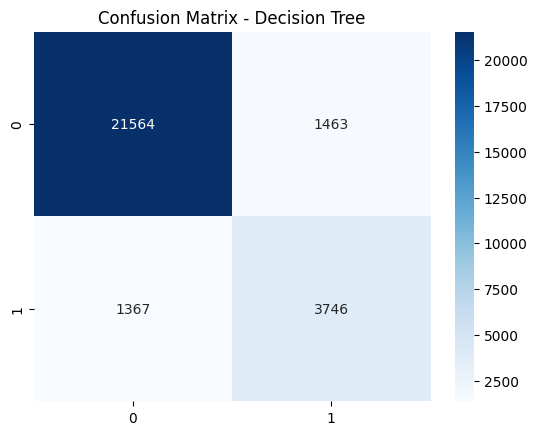

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Inicializar e treinar
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Previsões
y_pred = dt_model.predict(X_test)

# Avaliação
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Decision Tree")
plt.show()

### Treino e Avaliação do k-Nearest Neighbors (k-NN)


k-NN Results
Accuracy: 0.8340085287846482
Precision: 0.5818518518518518
Recall: 0.3072560140817524
F1 Score: 0.4021502623832075


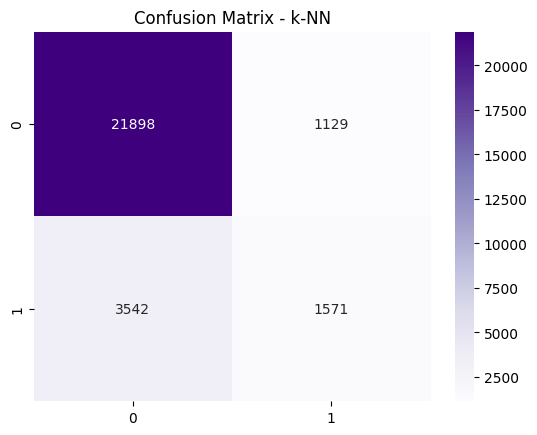

In [11]:
from sklearn.neighbors import KNeighborsClassifier

# Inicializar e treinar
knn_model = KNeighborsClassifier(n_neighbors=5)  # podes depois ajustar o k
knn_model.fit(X_train, y_train)

# Previsões
y_pred_knn = knn_model.predict(X_test)

# Avaliação
print("k-NN Results")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn))
print("Recall:", recall_score(y_test, y_pred_knn))
print("F1 Score:", f1_score(y_test, y_pred_knn))

# Matriz de Confusão
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - k-NN")
plt.show()


### Treino e Avaliação do Support Vector Machine (SVM)


SVM Results
Accuracy: 0.8828002842928216
Precision: 0.9100768187980117
Recall: 0.3938979072951301
F1 Score: 0.5498225498225499


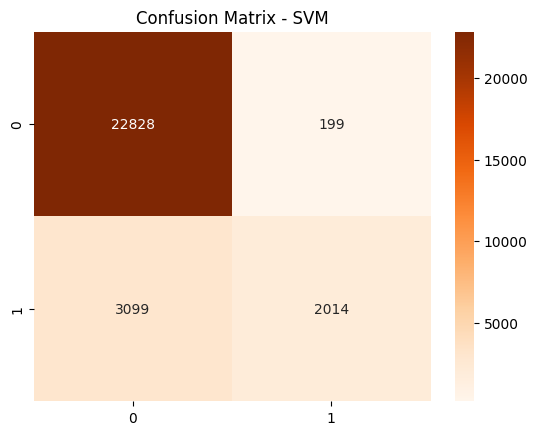

In [12]:
from sklearn.svm import SVC

# Inicializar e treinar
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

# Previsões
y_pred_svm = svm_model.predict(X_test)

# Avaliação
print("SVM Results")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm))
print("Recall:", recall_score(y_test, y_pred_svm))
print("F1 Score:", f1_score(y_test, y_pred_svm))

# Matriz de Confusão
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - SVM")
plt.show()


### Comparação dos 3 Modelos (Gráfico)

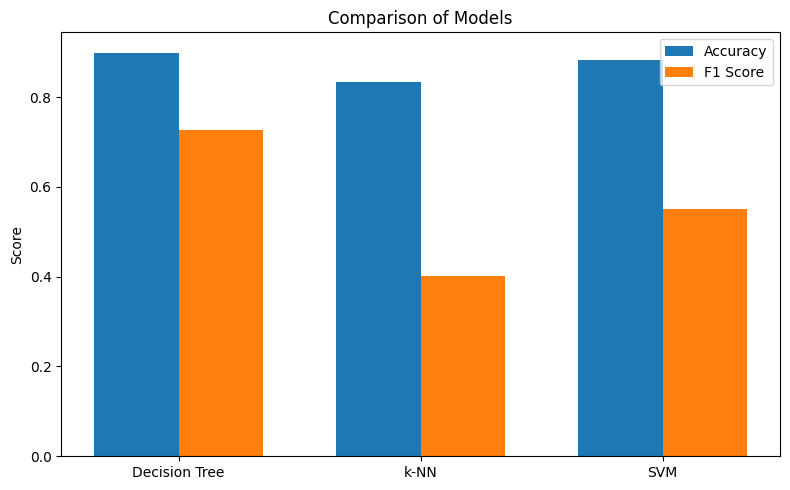

In [14]:
# Guardar as métricas em listas
models = ['Decision Tree', 'k-NN', 'SVM']
accuracies = [
    accuracy_score(y_test, y_pred),      # Decision Tree (y_pred já treinado antes)
    accuracy_score(y_test, y_pred_knn),  # k-NN
    accuracy_score(y_test, y_pred_svm)   # SVM
]

f1_scores = [
    f1_score(y_test, y_pred),
    f1_score(y_test, y_pred_knn),
    f1_score(y_test, y_pred_svm)
]

# Gráfico de comparação
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score')

ax.set_ylabel('Score')
ax.set_title('Comparison of Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()
